In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
import keras.preprocessing.image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.layers import preprocessing
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image

*Курсив*# **Разархивация данных**

In [ ]:
!unzip -q '/content/copybook_train.zip' -d ''

In [ ]:
!unzip -q '/content/copybook_test.zip' -d ''

# **Задаём константы**

In [ ]:
PATH_TRAIN = '/content/copybook_train'
PATH_TEST = '/content/copybook_test'

IMAGE_SIZE = (224, 224)
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = len(os.listdir(PATH_TEST + '/1')) + len(os.listdir(PATH_TEST + '/0'))

# **Проверка правильности путей и количества данных**

In [ ]:
print(f"количество фото без тетради в тренировочном датасете {len(os.listdir(PATH_TRAIN + '/0'))}")
print(f"количество фото с тетрадью в тренировочном датасете {len(os.listdir(PATH_TRAIN + '/1'))}")

print(f"количество фото без тетради в тестовом датасете {len(os.listdir(PATH_TEST + '/0'))}")
print(f"количество фото с тетрадью в тестовом датасете {len(os.listdir(PATH_TEST + '/1'))}")

количество фото без тетради в тренировочном датасете 139
количество фото с тетрадью в тренировочном датасете 139
количество фото без тетради в тестовом датасете 7
количество фото с тетрадью в тестовом датасете 7


# **Создаем генераторы изображений**

In [ ]:
train_datagen = ImageDataGenerator(
                    rescale=1. / 255.,
                    validation_split=0.1,
                    horizontal_flip=True,
                    vertical_flip=True,
                    zoom_range = [0.95, 1.05]
                )

train_ds = train_datagen.flow_from_directory(
    PATH_TRAIN,
    target_size=(IMAGE_SIZE[1], IMAGE_SIZE[0]),
    batch_size=BATCH_SIZE_TRAIN,
    class_mode='binary',
    shuffle=True,
    subset='training'
)

validation_ds = train_datagen.flow_from_directory(
    PATH_TRAIN,
    target_size=(IMAGE_SIZE[1], IMAGE_SIZE[0]),
    batch_size=BATCH_SIZE_TRAIN,
    class_mode='binary',
    shuffle=True,
    subset='validation'
)


test_datagen = ImageDataGenerator(
                    rescale=1. / 255.
                )


test_ds = test_datagen.flow_from_directory(
    PATH_TEST,
    target_size=(IMAGE_SIZE[1], IMAGE_SIZE[0]),
    batch_size = BATCH_SIZE_TEST,
    class_mode='binary'
)

Found 252 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Found 14 images belonging to 2 classes.


# **Печать изображений без аугментации**

In [ ]:
# определяем количество батчей костылями
n = 0
while True:
    try:
        train_ds[n]
        n += 1
    except:
        break

        
fig, axs = plt.subplots(5, 5, figsize = (25, 25))
for i in range(len(axs)):
    for j in range(len(axs[0])):
        rnd_class_name = str(int(random.choice(train_ds[0][1])))
        rnd_file_name = random.choice(os.listdir(PATH_TRAIN + '/' + rnd_class_name))
        axs[i][j].imshow(Image.open(PATH_TRAIN + '/' + rnd_class_name + '/'+ rnd_file_name))
        axs[i][j].set_title(rnd_class_name)
        axs[i][j].axis('off')

Output hidden; open in https://colab.research.google.com to view.

# **Печать изображений через генератор, проверка аугментации**

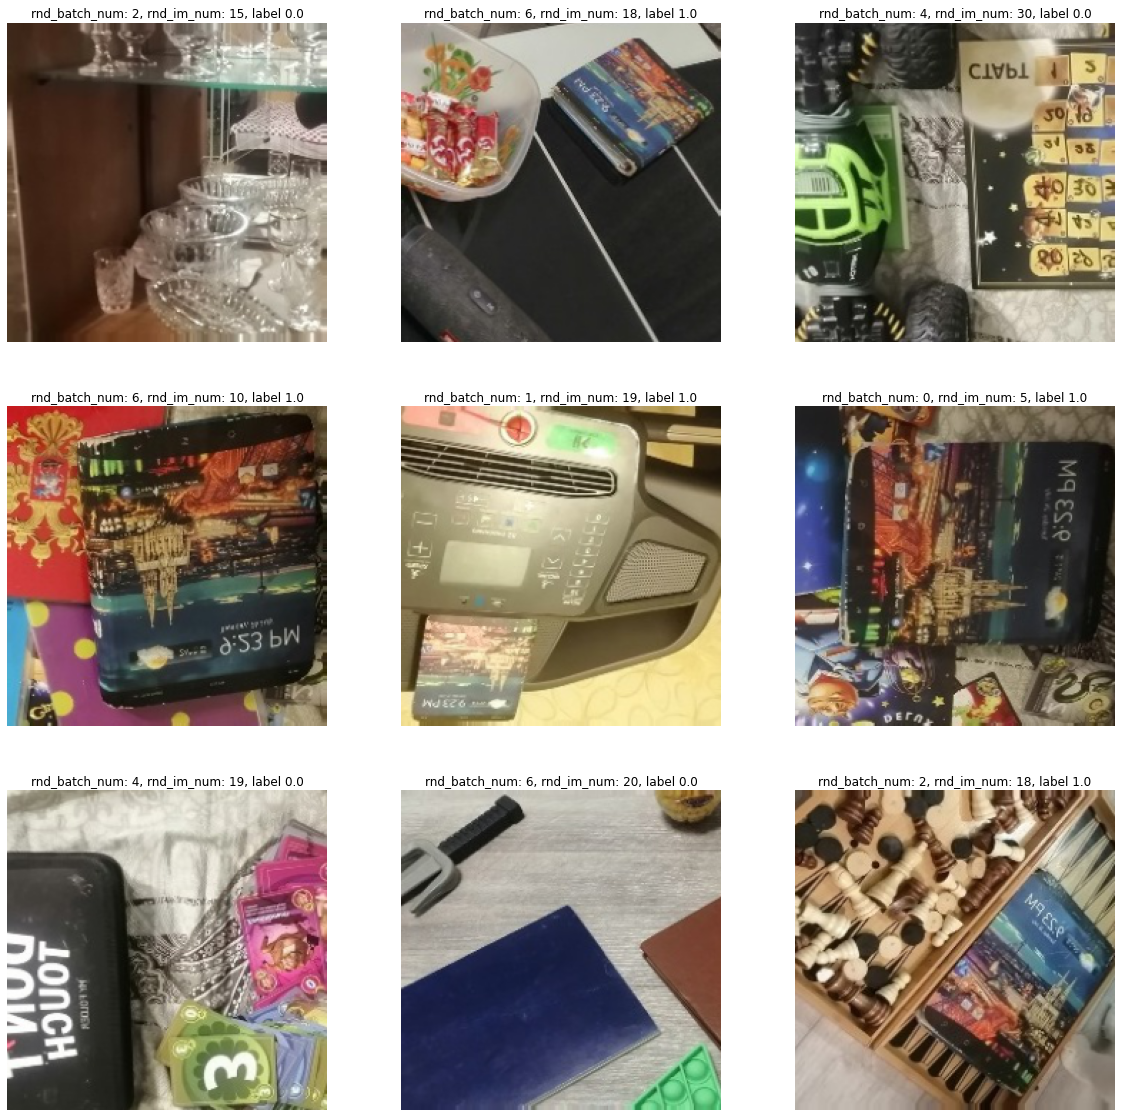

In [ ]:
n = 0
while True:
    try:
        train_ds[n]
        n += 1
    except:
        break
        
        
fig, axs = plt.subplots(3, 3, figsize = (20, 20))
for i in range(len(axs)):
    for j in range(len(axs[0])):
        rnd_batch_num = random.choice(range(n))
        rnd_im_num = random.choice(range(train_ds[rnd_batch_num][0].shape[0]))
        axs[i][j].set_title(f'rnd_batch_num: {rnd_batch_num}, rnd_im_num: {rnd_im_num}, label {train_ds[rnd_batch_num][1][rnd_im_num]}')
        axs[i][j].imshow(train_ds[rnd_batch_num][0][rnd_im_num])
        axs[i][j].axis('off')

# **Создание модели**

In [ ]:
#model = keras.applications.VGG16()
model = VGG16(weights='imagenet')

In [ ]:
vgg16_net = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg16_net.trainable = False

In [ ]:
model = Sequential()
model.add(vgg16_net)
model.add(Flatten())
model.add(Dense(4096, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 4096)              102764544 
                                                                 
 dense_3 (Dense)             (None, 1)                 4097      
                                                                 
Total params: 117,483,329
Trainable params: 102,768,641
Non-trainable params: 14,714,688
_________________________________________________________________


# **Компиляция и обучение**

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
model.fit_generator(train_ds, validation_data = validation_ds, shuffle=True, epochs=5, verbose=1)

<ipython-input-35-1d2fa5226dff>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_ds, validation_data = validation_ds, shuffle=True, epochs=5, verbose=1)


Epoch 1/5
10/10 [==============================] - 228s 23s/step - loss: 2.2383 - accuracy: 0.5502 - val_loss: 0.9663 - val_accuracy: 0.5000
Epoch 2/5
10/10 [==============================] - 246s 25s/step - loss: 0.6543 - accuracy: 0.7023 - val_loss: 0.2710 - val_accuracy: 0.9118
Epoch 3/5
10/10 [==============================] - 247s 25s/step - loss: 0.3466 - accuracy: 0.8511 - val_loss: 0.1320 - val_accuracy: 1.0000
Epoch 4/5
10/10 [==============================] - 227s 23s/step - loss: 0.1860 - accuracy: 0.9385 - val_loss: 0.1747 - val_accuracy: 0.9118
Epoch 5/5
10/10 [==============================] - 252s 25s/step - loss: 0.1392 - accuracy: 0.9547 - val_loss: 0.1337 - val_accuracy: 0.9706


# **Сохранить веса**

In [ ]:
model.save_weights('model.h5')

# **Проверка на тестовой выборке**



In [ ]:
scores = model.evaluate_generator(test_ds)

<ipython-input-37-13983526457c>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_ds)


In [ ]:
scores

[0.4466814696788788, 0.8571428656578064]

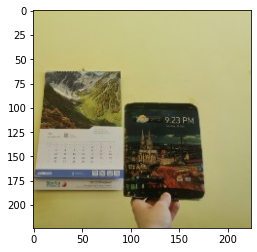

In [ ]:
im = np.expand_dims(test_ds[0][0][9], axis=0)
plt.imshow(im[0])

In [ ]:
model.predict(im)

1/1 [==============================] - 1s 635ms/step


array([[0.96320575]], dtype=float32)

# **Черновик**

# **Проверка вручную**

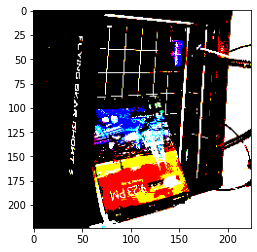

In [ ]:
#img = keras.preprocessing.image.load_img('/content/copybook_test/0/IMG_20230213_133651.jpg', target_size=(224, 224))
#im = np.array(Image.open('/content/copybook/1/IMG_20230130_084300.jpg'))
im = Image.open('/content/copybook_train/1/IMG_20230130_230827.jpg')
im.thumbnail((224, 224))
#im = train_ds[2][0][2]
im = np.expand_dims(im, axis=0)
im = preprocess_input(im)
plt.imshow(im[0])

In [ ]:
preds = model.predict(im)
preds
#print(decode_predictions(preds, top=3))

1/1 [==============================] - 1s 632ms/step


array([[0.]], dtype=float32)

In [ ]:
model = Sequential()
model.add(ZeroPadding2D(padding=(5,5), input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
model.add(Conv2D(96, (11,11), padding = 'valid',strides = (2,2), activation = 'relu'))

model.add(ZeroPadding2D(padding=(3,3)))
model.add(Conv2D(256, (5,5), padding = 'valid', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# ->(1, 28, 28, 256)

model.add(ZeroPadding2D(padding=(1,1)))
model.add(Conv2D(384, (3,3), padding = 'valid', activation = 'relu', ))
model.add(MaxPooling2D(pool_size=(2,2)))
# -> (1, 14, 14, 384)

model.add(Conv2D(384, (3,3), padding = 'same', activation = 'relu', ))
# -> (1, 14, 14, 384)
model.add(Conv2D(256, (3,3), padding = 'same', activation = 'relu', ))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(4096, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 234, 234, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 96)      34944     
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 118, 118, 96)     0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 114, 114, 256)     614656    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 57, 57, 256)      0         
 )                                                               
                                                        

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
model.fit(train_ds, validation_data = validation_ds, shuffle=True, epochs=30, verbose=1)

Epoch 1/30
8/8 [==============================] - 279s 34s/step - loss: 7.6060 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/30
8/8 [==============================] - 272s 35s/step - loss: 0.6984 - accuracy: 0.5000 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 3/30
8/8 [==============================] - 275s 34s/step - loss: 0.6942 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 4/30
8/8 [==============================] - 273s 34s/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/30
8/8 [==============================] - 277s 35s/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/30
6/8 [=====================>........] - ETA: 1:07 - loss: 0.6935 - accuracy: 0.4840

KeyboardInterrupt: ignored

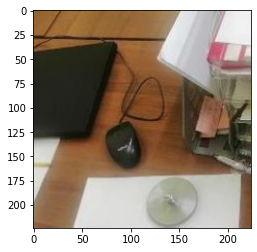

In [ ]:
n = 21
plt.imshow(train_ds[0][0][n])
im = np.array(train_ds[0][0][n])
im = np.expand_dims(im, axis=0)

In [ ]:
model.predict(im)

1/1 [==============================] - 1s 738ms/step


array([[0.5020109]], dtype=float32)

In [ ]:
'''
fig, axs = plt.subplots(5, 5, figsize = (25, 25))
for i in range(len(axs)):
    for j in range(len(axs[0])):
        rnd_class_name = random.choice(class_names)
        rnd_file_name = random.choice(os.listdir('..\\data\\copybook\\' + rnd_class_name))
        axs[i][j].imshow(Image.open("..\\data\\copybook\\" + rnd_class_name + '\\'+ rnd_file_name))
        axs[i][j].set_title(rnd_class_name)
        axs[i][j].axis('off')
'''

In [ ]:
'''
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  PATH_TRAIN,                # Путь к изображениям
  validation_split = 0.1,    # Устанавливаем разделение на обучающую и проверочную выборки (10%)
  subset = "training",       # Помечаем, что выборка обучающая (90%)
  seed = 123,                # Дополнительное случайное начальное число для перетасовки и преобразований
  image_size = IMAGE_SIZE,   # Размер изображений, который был задан ранее
  batch_size = BATCH_SIZE,   # Размер батча, который был задан ранее
  shuffle = True)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  PATH_TRAIN,                # Путь к изображениям
  validation_split = 0.1,    # Устанавливаем разделение на обучающую и проверочную выборки (10%)
  subset = "validation",     # Помечаем, что выборка проверочная (10%)
  seed = 123,                # Дополнительное случайное начальное число для перетасовки и преобразований
  image_size = IMAGE_SIZE,   # Размер изображений, который был задан ранее
  batch_size = BATCH_SIZE,   # Размер батча, который был задан ранее
  shuffle = True)
                             # Определяем имена классов:
class_names = train_ds.class_names
print(class_names)
'''

In [ ]:
'''
list_path = [PATH_TRAIN_0_1077х808, PATH_TRAIN_1_1077х808]

for path in list_path:
    list_name = os.listdir(path)

    for name in list_name:
        im = Image.open(path + '\\' + name)
        im = np.array(im)
        if im.shape == (1077, 808, 3):
            im_new = np.zeros((808,1077, 3))
            im_new[:,:,0] = im[:,:,0].transpose()
            im_new[:,:,1] = im[:,:,1].transpose()
            im_new[:,:,2] = im[:,:,2].transpose()
            matplotlib.image.imsave(path + '\\' + name, im_new / 255.)
            im_new = im_new.astype(np.int64)
#            plt.imshow(im_new)
#            print(im_new.shape)
#            break
'''

In [ ]:
'''
from PIL import Image
import matplotlib.image


save_datagen = ImageDataGenerator()

save_ds = train_datagen.flow_from_directory(
    PATH_TRAIN,
    target_size=(IMAGE_SIZE[1], IMAGE_SIZE[0]),
    class_mode='categorical',
    subset='training'
)

# определяем количество батчей костылями
n = 0
while True:
    try:
        save_ds[n]
        n += 1
    except:
        break
        
name_num = 0        
for i in range(n):
    for j in range(save_ds[i][1].shape[0]):
        #plt.imshow(train_ds[i][0][j])
        matplotlib.image.imsave('..\\data\\copybook\\copybook_train_1088х816' + '\\' + str((int(save_ds[i][1][j][1])))+ '\\'  + str(name_num) + '.jpg', save_ds[i][0][j])
        name_num += 1
'''